# Import Required Libraries

In [1]:
import sys
import os
os.chdir("..")
os.chdir("..")
os.chdir("./src")
# sys.path.append("./src")

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.io
from tqdm import tqdm
from scipy.stats import invgamma, chi2, t
from WSMBSS import *
from numba import njit
from IPython import display
import pylab as pl
import mne 
from mne.preprocessing import ICA
import warnings
warnings.filterwarnings("ignore")
# np.random.seed(157)
# %load_ext autoreload
# %autoreload 2
notebook_name = 'Antisparse_Copula'

# Source Generation and Mixing Scenario

In [3]:
rho = 0.0
N = 500000
NumberofSources = 5
NumberofMixtures = 10

M = NumberofMixtures
r = NumberofSources

SNR = 30 # dB
NoiseAmp = (10 ** (-SNR/20))# * np.sqrt(NumberofSources)

S = generate_correlated_copula_sources(rho = rho, df = 4, n_sources = NumberofSources, size_sources = N , 
                                       decreasing_correlation = True)
# S = 2 * S - 1

A = np.random.standard_normal(size=(NumberofMixtures,NumberofSources))
Xn = A @ S
Noisecomp=np.random.randn(A.shape[0],S.shape[1])*np.power(10,-SNR/20)#*INPUT_STD
X=Xn+Noisecomp
SNRinp = 20*np.log10(np.std(Xn)/np.std(Noisecomp))

print("The following is the mixture matrix A")
display_matrix(A)
print("Input SNR is : {}".format(SNRinp))

The following is the mixture matrix A


<IPython.core.display.Math object>

Input SNR is : 30.067609080034188


# Visualize Generated Sources and Mixtures

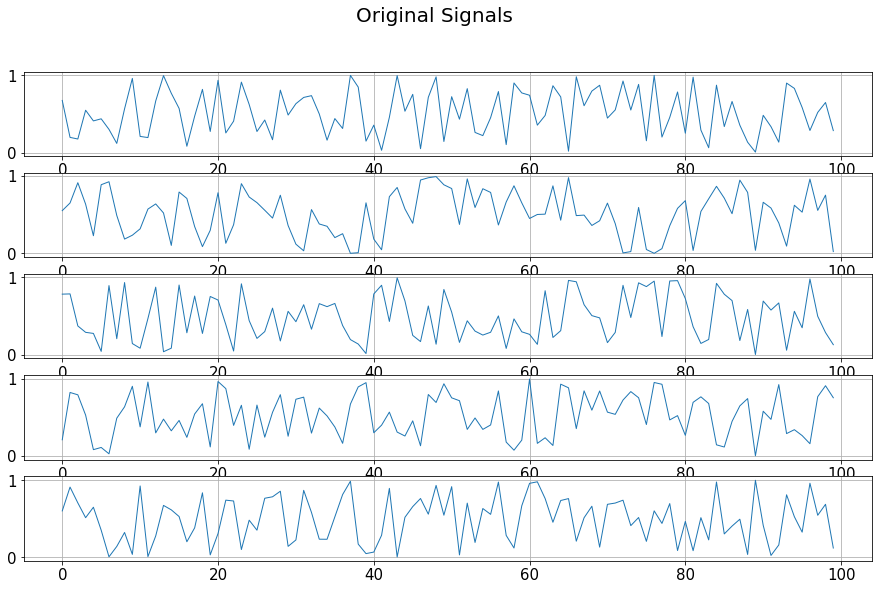

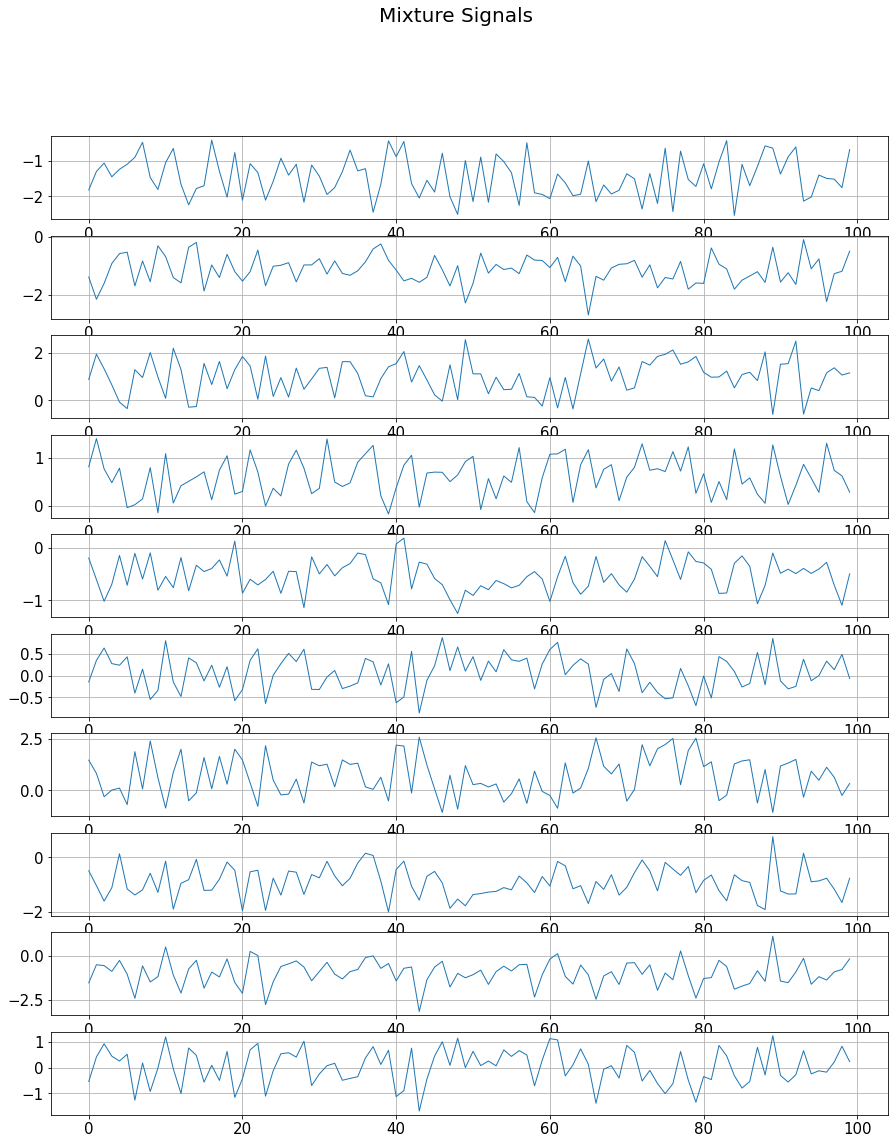

In [4]:
subplot_1D_signals(S.T[0:100], title = 'Original Signals', figsize = (15.2,9), colorcode = None)
subplot_1D_signals(X.T[0:100], title = 'Mixture Signals', figsize = (15,18), colorcode = None)

# Algorithm Hyperparameter Selection and Weight Initialization

In [5]:
debug_iteration_point = 10000
gamma = np.sqrt(1 - 1e-3)

# Run BSM Algorithm on Mixture Signals

In [6]:
model = OnlineBSM(s_dim = NumberofSources, x_dim = NumberofMixtures, beta = 1e-6, 
                  gamma = gamma, whiten_input_ = True,
                  neural_OUTPUT_COMP_TOL = 1e-7)

model.fit_batch_nnantisparse(X = X, n_epochs = 1, neural_dynamic_iterations = 750,
                           neural_lr_start = 2.5, neural_lr_stop = 1e-15, fast_start = True,
                           debug_iteration_point = debug_iteration_point)

100%|██████████| 500000/500000 [00:45<00:00, 10903.81it/s]


# Calculate Resulting Component SNRs and Overall SINR

In [7]:
Wf = model.compute_overall_mapping(return_mapping = True)
Y = Wf @ X
Y_ = signed_and_permutation_corrected_sources(S.T,Y.T)
coef_ = (Y_ * S.T).sum(axis = 0) / (Y_ * Y_).sum(axis = 0)
Y_ = coef_ * Y_

print("Component SNR Values : {}\n".format(snr(S.T, Y_)))

SINRwsm = 10*np.log10(CalculateSINR(Y_.T, S)[0])

print("Overall SINR : {}".format(SINRwsm))

Component SNR Values : [30.98037741 29.90395162 34.33149353 29.24961221 31.95272651]

Overall SINR : 30.99966501373864


# Vizualize Extracted Signals Compared to Original Sources

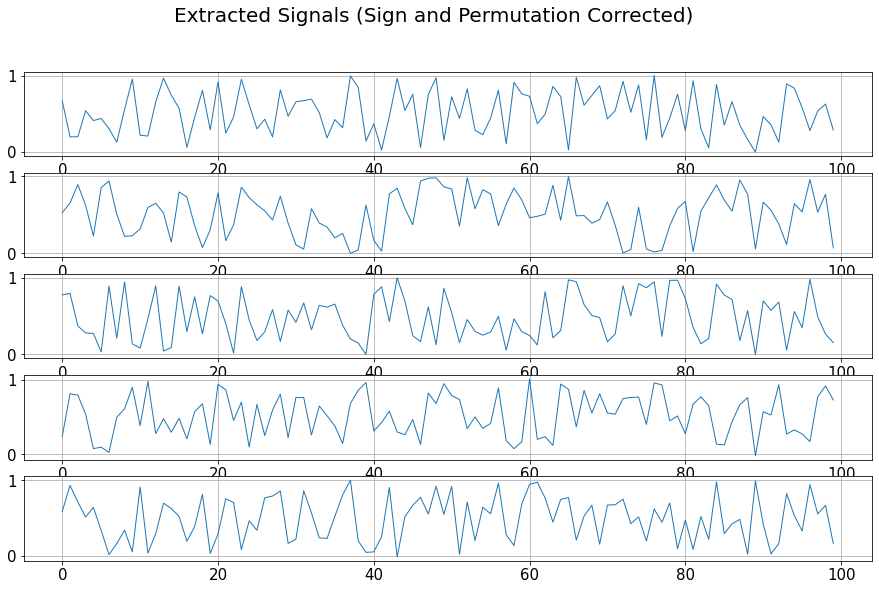

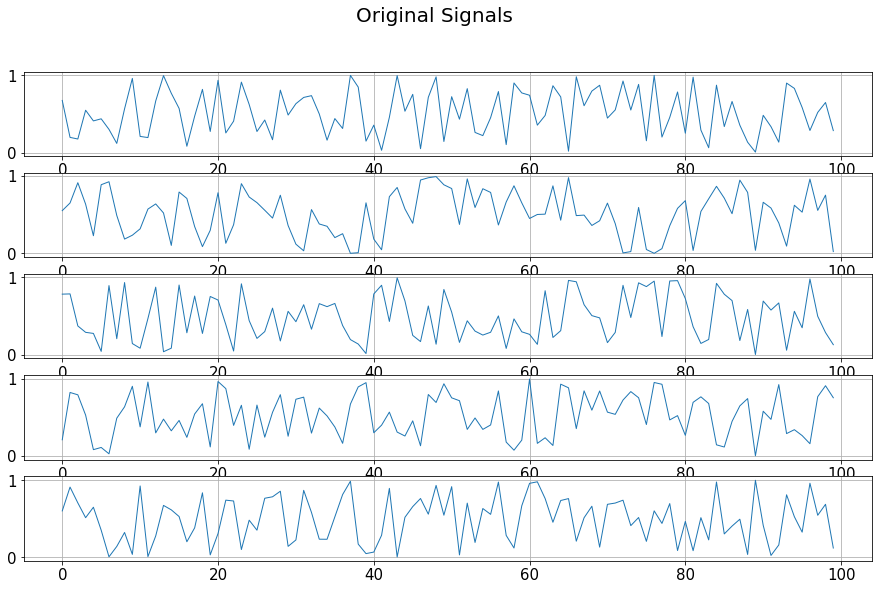

In [8]:
subplot_1D_signals(Y_[0:100], title = 'Extracted Signals (Sign and Permutation Corrected)', figsize = (15.2,9), colorcode = None)
subplot_1D_signals(S.T[0:100], title = 'Original Signals', figsize = (15.2,9), colorcode = None)